# HNCDI Explain:  Grover Tutorial 1

### Install the qiskit library in the colab environment

Please run the below cell to ensure the notebook has qiskit installed.

In [2]:
# Install the qiskit library
%pip install 'qiskit[visualization]'
%pip install qiskit-ibm-runtime
%pip install qiskit-aer

  Using cached matplotlib-3.9.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pydot-2.0.0-py3-none-any.whl.metadata (9.6 kB)
  Using cached pillow-10.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pylatexenc-2.10-py3-none-any.whl
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.52.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (161 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached pandas-2.2.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached matplotlib-3.9.0-cp311-cp311-macosx_11_0_arm64.whl (7.8

### Import the necessary modules from the Qiskit library


In [4]:
import numpy as np
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as real_sampler
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile

# TODO: IBMQ was not imported, might be needed

### Authenticate with IBM quantum

You will require the API token specified in the IBM quantum platform to ensure you can execute your code on a real quantum computer.

In [5]:
my_token = "<Paste your token here>"

service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

This is tutorial 1 on Grover's Algorithm. This is a 2-qubit example, with 1-Grover iteration. 

__Task__. In cell 2, modify the circuit for the oracle which marks different items. You should find that changing the circuit outputs a different bit-string corresponding to the good item. 

We will then implement Grover's algorithm, which can can be described in 3 main steps.

1. Create the superposition state $|s \rangle$.
2. Apply the circuit for the black box.
3. Apply the Grover Diffusion operator.

We will then submit this circuit to: 1) a simulator, 2) real quantum hardware.

__Task__. In the cell below, we will create the quantum circuit for the oracle that implements $f$. There are 4 different circuits that implement $f(x_m)$ for a different bit string $x_m$. By commenting out different circuits, see how this changes the good item found through Grover's algorithm.

As an example, remove the comments for qc.cz(0,1) and comment out the circuits below the remaining bit strings.

Matplotlib is building the font cache; this may take a moment.


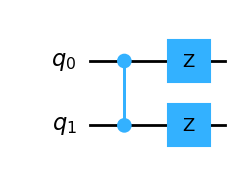

In [6]:
## Here we will create a quantum circuit for the oracle
qc = QuantumCircuit(2) 

### COMMENT OUT VARIUS CIRCUITS HERE ###

## 00 ## 
qc.cz(0,1)
qc.z(0)
qc.z(1)

## 01 ## 
#qc.cz(0,1)
#qc.z(0)

## 10 ## 
#qc.cz(0,1)
#qc.z(1)

## 11 ## 
#qc.cz(0,1)

#Draw black box circuit
qc.draw('mpl') 

We will now step through Grover's algorithm. 

__Step 1__: Create the superposition state $|s \rangle$. To do this we will first create a quantum circuit of $n=2$ qubits and then apply a layer of Hadamard Gates, creating the state $|s \rangle = \sum_{x\in \{0,1\}^n} |x \rangle $.

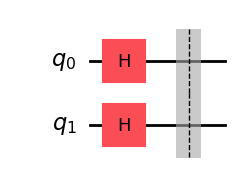

In [7]:
# Define no. of qubits to be n = 2 and create a quantum circuit called "circ" with an n-qubit register.
n = 2
circ = QuantumCircuit(n)

#Apply a Hadamard gate to each qubit in the circuit.
for i in range(n):
    circ.h(i)

circ.barrier()
circ.draw('mpl') 

 __Step 2__. Apply the circuit for the black box. Apply the black box circuit $U_{O}$ that we have explicitly constructed and apply it to the state $|s \rangle $.

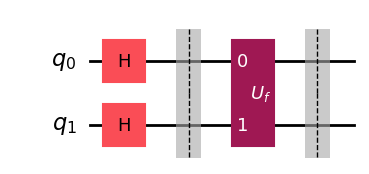

In [8]:
# Create a quantum circuit with a CZ gate
oracle = qc.to_gate()
oracle.name = "$U_f$"
circ.append(oracle, [0,1])
circ.barrier()
circ.draw('mpl') 

Step 3. Apply the Grover Diffusion operator.



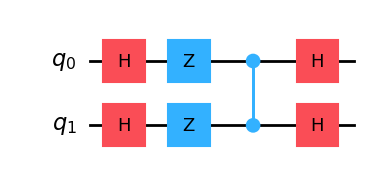

In [9]:
qc = QuantumCircuit(2)

for i in range(n):
    qc.h(i)
    qc.z(i)
    
qc.cz(0,1)
qc.h([0,1])

#draw diffuser
qc.draw('mpl')

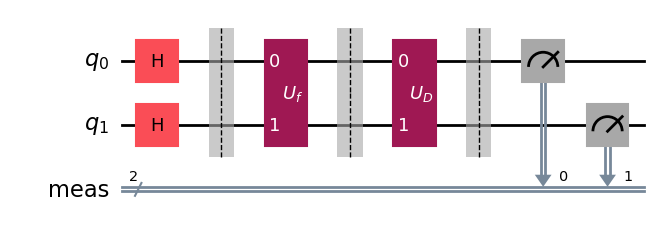

In [10]:
diffuser = qc.to_gate()
diffuser.name = "$U_D$"
circ.append(diffuser, [0,1])
circ.measure_all()
circ.draw('mpl') 

__Step 4__: We will now submit the quantum circuit to A) a simulator and B) a real quantum computer. 

In theory, we should find the bit-string corresponding to the good item $x_m$ with certainty.

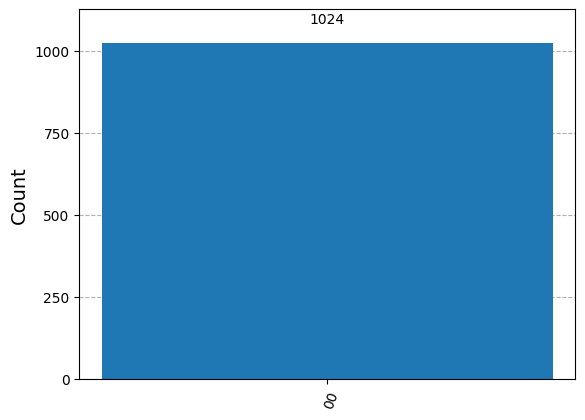

In [11]:
# OPTION 1: RUN ON QUANTUM SIMULATOR
sim = AerSimulator()
sampler = SamplerV2()
t_circ = transpile(circ, sim, optimization_level=3)
results = sampler.run([t_circ], shots=1024).result()
answer = results[0].data.meas.get_counts()
plot_histogram(answer)

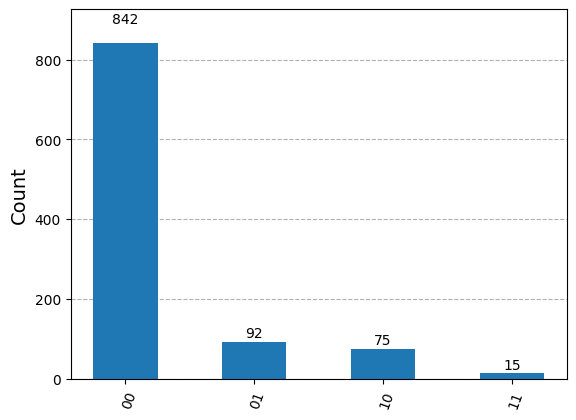

In [12]:
# OPTION 2: RUN ON QUANTUM HARDWARE

backend = service.least_busy(operational=True, simulator=False)
sampler = real_sampler(backend)
t_circ = transpile(circ, backend, optimization_level=3)
job = sampler.run([t_circ], shots=1024)
results = job.result()
answer = results[0].data.meas.get_counts()
plot_histogram(answer)